In [285]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import cv2 
import random

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import preprocessing
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [286]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


# Detect mobile objects using Background Substraction

In [4]:
def object_moving_detection(video_seq):
    # Create a VideoCapture object
    cap = cv2.VideoCapture(video_seq)
 
    # Create the background subtractor object
    # Use the last 200 video frames to build the background    
    back_sub = cv2.createBackgroundSubtractorMOG2(history=200, detectShadows=False)
 
    # Create kernel for morphological operation
    # You can tweak the dimensions of the kernel
    # e.g. instead of 20,20 you can try 30,30.
    kernel = np.ones((20,20),np.uint8)
    
    

    while(cap.isOpened()):
 
        ret, frame_col = cap.read()
    
        if ret : 
    
            frame = cv2.cvtColor(frame_col, cv2.COLOR_BGR2GRAY)
            frame = cv2.GaussianBlur(frame, (3, 3), 0)

            # Use every frame to calculate the foreground mask and update
            # the background
            fg_mask = back_sub.apply(frame)

            # Close dark gaps in foreground object using closing
            fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_CLOSE, kernel)

            # Remove salt and pepper noise with a median filter
            fg_mask = cv2.medianBlur(fg_mask, 5) 

            # Threshold the image to make it either black or white
            _, fg_mask = cv2.threshold(fg_mask,127,255,cv2.THRESH_BINARY)

            # Find the index of the largest contour and draw bounding box
            fg_mask_bb = fg_mask

            contours, hierarchy = cv2.findContours(fg_mask_bb,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)


            areas = [cv2.contourArea(c) for c in contours]

            # If there are no countours
            if len(areas) < 1:

                # Display the resulting frame
                cv2.imshow('frame',frame)

                # If "q" is pressed on the keyboard, 
                # exit this loop
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

                # Go to the top of the while loop
                continue

            else:
                # Find the largest moving object in the image
                max_index = np.argmax(areas)

            # Draw the bounding box
            cnt = contours[max_index]
            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(frame_col,(x,y),(x+w,y+h),(0,255,0),3)



            # Display the resulting frame
            cv2.imshow('frame',frame_col)

            # If "q" is pressed on the keyboard, 
            # exit this loop
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        else:
            break

        # Close down the video stream
    cap.release()
    cv2.destroyAllWindows()
 


In [ ]:
folders = glob.glob(".\AVDIAR_ALL\*")

for folder in folders[:2]:

    video_seq = glob.glob(folder+"\Video\*1.mp4")  

    object_moving_detection(video_seq[0])
    


# 2. Comparing MLP with the GT of AVDIAR Dataset using IOU

In [27]:
def coord_random_rectangle(face_box, image_shape):
    
    x1, y1, x2, y2 = face_box 
    
    xi1 = random.randint(0, image_shape[1] - (x2 - x1))
    yi1 = random.randint(0, image_shape[0] - (y2 - y1))
    
    
    xi2 = xi1 + (x2 - x1)
    yi2 = yi1 + (y2 - y1)
    
    return (xi1,  yi1, xi2, yi2)

In [30]:
def intersection_over_union(current_face_box, random_rectangle ):
    
    l1, t1, r1, b1 =  current_face_box
    l2, t2, r2, b2 =  random_rectangle
    
    
    li = max(l1, l2)
    ti = max(t1, t2)
    ri = min(r1, r2)
    bi = min(b1, b2)
    
    inter = max(ri-li+1, 0)*max(bi-ti+1,0)
    
    area1 = (r1-l1+1)*(b1-t1+1)
    area2 = (r2-l2+1)*(b2-t2+1)
    union =  area1 + area2 - inter 
    
    
    return inter/union

In [31]:
def window_background(current_face_box, image_shape, face_boxes, iou_threshold ):

    while True:
        
        iou = 0
        
        random_rectangle = coord_random_rectangle(current_face_box, image_shape)
        
        for face_box in face_boxes: 
            iou = max(intersection_over_union(face_box, random_rectangle ), iou)
        
        if iou < iou_threshold:
            break
            
    return random_rectangle
        
        

# 2.1 Save backs and the detected faces in video seq available in the GT 

In [ ]:
folders = glob.glob(".\AVDIAR_ALL\*")
color = (0, 255, 0)
thickness = 3

cptfaces = 0
cptbackground = 0

print(len(folders))
for ind, folder in enumerate(folders):
    print(ind)
    video_seq = glob.glob(folder+"\Video\*1.mp4")

    cap = cv2.VideoCapture(video_seq[0])
    
    cpt = 0
    
    with open(folder+'\GroundTruth\\face_bb.txt') as file:
        
        line = file.readline().strip("\n")
        frame_info =  [int(float(i)) for i in line.split(",")[:6]]
        
        while(True):
                
                 # Capture frame-by-framea
                ret, frame = cap.read() 
                
                if ret: 
                    face_boxes = []
                    
                    while frame_info[0] == cpt  : 
                        
                        top, left  = (frame_info[2], frame_info[3])
                        bottom, right = (top + frame_info[4], left + frame_info[5])

                        #frame = cv2.rectangle(frame, (top, left), (bottom, right), color, thickness)
                        
                        face = frame[left:right, top:bottom]
                        
                        cv2.imwrite("./DatasetAVDIAR/faces/"+str(cptfaces)+'.jpg', face)
                        cptfaces += 1                        
                        
                        face_boxes.append((top, left, bottom, right))
                        
                        line = file.readline().strip("\n")
                        
                        if not line : 
                            break
                        frame_info =  [int(float(i)) for i in line.split(",")[:6]]
                            
                    #plt.imshow(frame)
                    #plt.show()
                   
                    for face_box in face_boxes:
                     
                        t, l, b, r = window_background( face_box , frame.shape, face_boxes, 0.05)
                        background = frame[l:r, t:b]
                        cv2.imwrite("./DatasetAVDIAR/background/"+str(cptbackground)+'.jpg', background)
                        cptbackground += 1
                       
                        

                    #cv2.imshow('frame',frame)
                    cpt += 1

                    if cv2.waitKey(25) & 0xFF == ord('q'):
                        break
                else:
                    break
                    
    cap.release()
    cv2.destroyAllWindows()
    
   

    

In [ ]:
folders = glob.glob(".\AVDIAR_ALL\*")

for ind, folder in enumerate(folders):
 
    video_seq = glob.glob(folder+"\Video\*1.mp4")  

    face_detection_violaJones(video_seq[0])

# 2.2 Build and train model MLP with faces and backs saved

In [46]:
height = 32
width = 32
img_window = (height, width, 3)
epochs = 20

train_ds = preprocessing.image_dataset_from_directory(
    directory = './DatasetAVDIAR/',
    validation_split=0.2,
    labels="inferred",
    label_mode='categorical',    
    color_mode="rgb",
    subset="training",
    class_names = ['background', "faces"],
    batch_size=256,
    image_size=(height, width),
    shuffle=True,
    seed = 0,
    
)

validation_ds = preprocessing.image_dataset_from_directory(
    directory = './DatasetAVDIAR/',
    validation_split=0.2,
    labels="inferred",
    label_mode='categorical' ,    
    color_mode="rgb",
    class_names = ['background', "faces"],
    subset="validation",
    batch_size=512,
    image_size=(height, width),
    shuffle=True,
    seed = 0,
    
)



Found 143762 files belonging to 2 classes.
Using 115010 files for training.
Found 143762 files belonging to 2 classes.
Using 28752 files for validation.


In [25]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='model_acc_videoSeq.hdf5', monitor='val_accuracy',verbose=1, save_weights_only=False,save_best_only=True)

In [26]:

nbr_units = height*width*3

model = Sequential([
  
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Input(shape = img_window),
  layers.Flatten(),  
  layers.Dense(1024, kernel_initializer='he_uniform',  activation = 'relu'),
  layers.Dense(512, kernel_initializer='he_uniform',  activation = 'relu'),
  layers.Dense(2, activation = 'softmax')
])


model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics=['accuracy', "AUC"])


In [48]:
history = model.fit(train_ds, epochs= epochs, validation_data=validation_ds, callbacks=[checkpointer])

Epoch 1/20
450/450 [==============================] - ETA: 0s - loss: 0.1742 - accuracy: 0.9481 - auc: 0.9838
Epoch 00001: val_accuracy did not improve from 0.99391
450/450 [==============================] - 109s 243ms/step - loss: 0.1742 - accuracy: 0.9481 - auc: 0.9838 - val_loss: 0.0639 - val_accuracy: 0.9813 - val_auc: 0.9964
Epoch 2/20
450/450 [==============================] - ETA: 0s - loss: 0.0578 - accuracy: 0.9832 - auc: 0.9967
Epoch 00002: val_accuracy did not improve from 0.99391
450/450 [==============================] - 108s 240ms/step - loss: 0.0578 - accuracy: 0.9832 - auc: 0.9967 - val_loss: 0.0509 - val_accuracy: 0.9852 - val_auc: 0.9970
Epoch 3/20
450/450 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 0.9874 - auc: 0.9980
Epoch 00003: val_accuracy did not improve from 0.99391
450/450 [==============================] - 109s 243ms/step - loss: 0.0424 - accuracy: 0.9874 - auc: 0.9980 - val_loss: 0.0389 - val_accuracy: 0.9889 - val_auc: 0.9979
Epoc

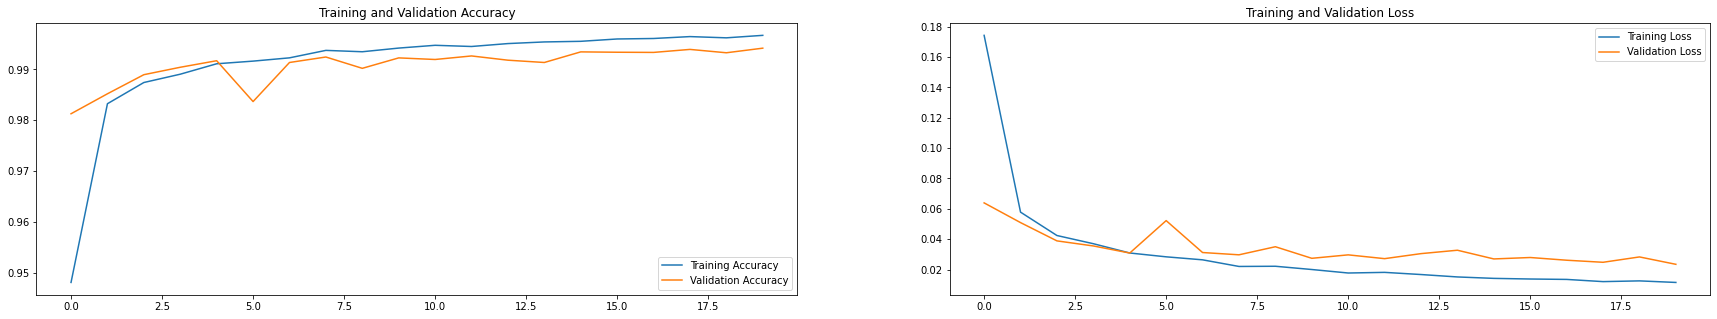

In [50]:
#vizualise
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = 20
epochs_range = range(epochs)

plt.figure(figsize=(30, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Test the model with faces and backs of the last 3 video seqs 

In [51]:
test_ds = preprocessing.image_dataset_from_directory(
    directory = './TestAVDIAR/',
    labels="inferred",
    label_mode='categorical',    
    color_mode="rgb",
    class_names = ['background', "faces"],
    image_size=(height, width),
    shuffle=False,
)
    

Found 10604 files belonging to 2 classes.


In [52]:
score = model.evaluate(test_ds)

332/332 [==============================] - 71s 213ms/step - loss: 0.6831 - accuracy: 0.8228 - auc: 0.8981


In [55]:
files_img = glob.glob('./TestAVDIAR/*/*')


dict_class = {'faces':1, 'background': 0}

y=[]
y_pred = []

for i,img_file in enumerate(files_img):
    img = keras.preprocessing.image.load_img( img_file, target_size=(height, width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
   
    score_eval = tf.nn.softmax(predictions[0])
    y_pred.append( np.argmax(score_eval))
   
    y.append(dict_class.get(img_file.split("\\")[-2]))
    



In [56]:
print("accuracy is "+str(score[1]))
print("f1 is "+str(f1_score(y,y_pred)))
print("recall is "+str(recall_score(y,y_pred)))
print("precision is "+str(precision_score(y,y_pred)))
print("AUC is "+str(score[2]))

accuracy is 0.822802722454071
f1 is 0.8024166480196913
recall is 0.6763485477178424
precision is 0.9862486248624862
AUC is 0.8980542421340942


# Test the model MLP trained using FDDB Dataset 

In [57]:
model.load_weights("model_acc.hdf5")

In [58]:
score = model.evaluate(test_ds)

332/332 [==============================] - 9s 26ms/step - loss: 0.2804 - accuracy: 0.8367 - auc: 0.9486


In [59]:
files_img = glob.glob('./TestAVDIAR/*/*')


dict_class = {'faces':1, 'background': 0}

y=[]
y_pred = []

for i,img_file in enumerate(files_img):
    img = keras.preprocessing.image.load_img( img_file, target_size=(height, width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
   
    score_eval = tf.nn.softmax(predictions[0])
    y_pred.append( np.argmax(score_eval))
   
    y.append(dict_class.get(img_file.split("\\")[-2]))
    



In [60]:
print("accuracy is "+str(score[1]))
print("f1 is "+str(f1_score(y,y_pred)))
print("recall is "+str(recall_score(y,y_pred)))
print("precision is "+str(precision_score(y,y_pred)))
print("AUC is "+str(score[2]))

accuracy is 0.8366653919219971
f1 is 0.8254633715798765
recall is 0.7055827989437948
precision is 0.9944178628389154
AUC is 0.9485942125320435


# 3. Build face detection and tracking

# 3.1 Build Viola Jones detector and tracker 

In [25]:
def face_detection_violaJones(video_seq, scaleFact = 1.1, size = 30):
    # Create a VideoCapture object
    cap = cv2.VideoCapture(video_seq)
 
    
    faceCascPath = ".\haarcascades\haarcascade_frontalface_default.xml"    
    faceCascade = cv2.CascadeClassifier(faceCascPath)
    
    profileCascPath =  ".\haarcascades\haarcascade_profileface.xml"
    profileCascade = cv2.CascadeClassifier(profileCascPath)

    
    with open(folder+'\Detection\\face_bb_Cascade.txt', 'w') as results:  
        
        cpt = 0
        
        while(cap.isOpened()):

            ret, frame = cap.read()

            if ret : 

                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                gray = cv2.GaussianBlur(gray, (3, 3), 0)


                faces = faceCascade.detectMultiScale(
                    gray,
                    scaleFactor= scaleFact,
                    minNeighbors=5,
                    minSize=(size, size),

                )

                profiles = profileCascade.detectMultiScale(
                    gray,
                    scaleFactor= scaleFact,
                    minNeighbors=5,
                    minSize=(size, size),

                )
                    
                number_faces = 0

                # Draw a rectangle around the faces
                for (x, y, w, h) in faces:
                    #cv2.rectangle(frame, (x, y), (x+w, y+h),(0,0, 255), 2)
                    results.write(str(cpt)+","+str(number_faces)+','+str(x)+','+str(y)+','+str(w)+','+str(h)+'\n')
                    number_faces+=1

                
            
                for (x, y, w, h) in profiles:
                    #cv2.rectangle(frame, (x, y), (x+w, y+h),(255,0, 0), 2)
                    results.write(str(cpt)+","+str(number_faces)+','+str(x)+','+str(y)+','+str(w)+','+str(h)+'\n')
                    number_faces+=1

                cpt += 1
                


                # Display the resulting frame
                #cv2.imshow('Video', frame)

                #if cv2.waitKey(1) & 0xFF == ord('q'):
                    #break


            else:
                break

        # Close down the video stream
    cap.release()
    cv2.destroyAllWindows()
 


# 3.2 Build DNN face detector and tracker

In [23]:
height = 32
width = 32

#Caffe model uses Single Shot-Multibox Detector (SSD) and uses ResNet-10 architecture as its backbone

def face_detection_caffe(folder, video_seq):
    
    # Create a VideoCapture object
    cap = cv2.VideoCapture(video_seq)
 
    
    modelFile = "CaffeModel/res10_300x300_ssd_iter_140000.caffemodel"
    configFile = "CaffeModel/deploy.prototxt.txt"
    net = cv2.dnn.readNetFromCaffe(configFile, modelFile)

        
    with open(folder+'\Detection\\face_bb_Caffe.txt', 'w') as results:  
        
        cpt = 0
        
        while(cap.isOpened()):

            ret, frame = cap.read()

            if ret : 
                
                h, w = frame.shape[:2]
                blob = cv2.dnn.blobFromImage(frame, 1.0, (frame.shape[1],frame.shape[0]))

                net.setInput(blob)
                faces = net.forward()

                number_faces = 0

                #to draw faces on image
                for i in range(faces.shape[2]):

                        confidence = faces[0, 0, i, 2]

                        if confidence > 0.5:

                            number_faces += 1

                            box = faces[0, 0, i, 3:7] * np.array([w, h, w, h])
                            (x, y, x1, y1) = box.astype("int")

                            #cv2.rectangle(frame, (x, y), (x1, y1), (255,0, 0), 2)

                            results.write(str(cpt)+","+str(number_faces)+','+str(x)+','+str(y)+','+str(x1-x)+','+str(y1-y)+'\n')  

                cpt += 1
                

                # Display the resulting frame
                #cv2.imshow('Video', frame)

                #if cv2.waitKey(1) & 0xFF == ord('q'):
                    #break


            else:
                break

            # Close down the video stream
    cap.release()
    cv2.destroyAllWindows()  


In [24]:
folders = glob.glob(".\AVDIAR_ALL\*")

for folder in folders:

    video_seq = glob.glob(folder+"\Video\*1.mp4")  

    face_detection_caffe(folder, video_seq[0])

In [64]:
#Test dnn algo with webcam
#face_detection_caffe(0)

In [80]:
#results using MLP model after retraining
print("f1 is "+str(f1_score(label_gt,label_pred)))
print("recall is "+str(recall_score(label_gt,label_pred)))
print("precision is "+str(precision_score(label_gt,label_pred)))


f1 is 0.11105450840550177
recall is 0.05879180151024811
precision is 1.0


In [ ]:
#results using MLP model obtained in the last lab

In [83]:
#results using MLP model 
print("f1 is "+str(f1_score(label_gt,label_pred)))
print("recall is "+str(recall_score(label_gt,label_pred)))
print("precision is "+str(precision_score(label_gt,label_pred)))


f1 is 0.0717628705148206
recall is 0.0372168284789644
precision is 1.0


# Evaluation of Caffe and Haar Cascade model in terms of:

# Precision, Recall, Number of missed faces, Number of New BB

In [297]:
def evaluation_detection_tech(folder, video_seq,  file_name, y_pred, y_gt, lack_faces, new_faces, iou_threshold):

    cap = cv2.VideoCapture(video_seq)
    
    with open(folder+'\GroundTruth\\face_bb.txt','r') as file, open(folder+'\Detection\\'+file_name+'.txt', 'r') as results:
        
        line = file.readline().strip("\n")
        frame_info =  [int(float(i)) for i in line.split(",")[:6]]
        
        line_res = results.readline().strip("\n")
        frame_info_res =  [int(float(i)) for i in line_res.split(",")]
        
        cpt = 0

        while(cap.isOpened()):

            ret, frame = cap.read()

            if ret :              
                
                faces_gt = []
                while frame_info[0] == cpt  : 

                    top, left  = (frame_info[2], frame_info[3])
                    bottom, right = (top + frame_info[4], left + frame_info[5])
                    
                    cv2.rectangle(frame, (top, left), (bottom, right), (255,0, 0), 2)
                    
                    faces_gt.append((top, left, bottom, right))
                    
                    line = file.readline().strip("\n")
                    

                    if not line: 
                        break

                    frame_info =  [int(float(i)) for i in line.split(",")[:6]]
                    
                   
                faces_pred = []
                while frame_info_res[0] == cpt:
                  
                    top_r, left_r  = (frame_info_res[2], frame_info_res[3])
                    bottom_r, right_r = (top_r + frame_info_res[4], left_r + frame_info_res[5])
                    
                    cv2.rectangle(frame, (top_r, left_r), (bottom_r, right_r), (0,255, 0), 2)
                    
                    faces_pred.append((top_r, left_r, bottom_r, right_r))
                    
                    line_res = results.readline().strip("\n")

                    if not line_res: 
                        break

                    frame_info_res =  [int(float(i)) for i in line_res.split(",")]

                cpt += 1

                gotpos= 0
                gotneg =0
                for ind, face_pred in enumerate(faces_pred):
                    
                    iou = -1     
                    
                    for face_gt in faces_gt:                        
                        iou = max(intersection_over_union(face_pred, face_gt), iou) 
                    
                    if iou > iou_threshold : 
                        y_pred.append(1)
                        gotpos+=1
                    elif iou > 0:
                        y_pred.append(0)
                        gotneg+=1
                                                                
                    
                    #cv2.putText(frame,'iou {:.2f}'.format(iou), (50+200*ind, 50),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_4) 
          
                new_f = max(len(faces_pred)-gotpos, 0)
                lack_f =  max(len(faces_gt) - (len(faces_pred)-new_f), 0)                
                      
                lack_faces += lack_f  
                new_faces += new_f
                                  
                y_pred.extend([0]*new_f)
                y_gt.extend([1]*(new_f+gotpos+gotneg))
        
  
                #cv2.putText(frame,'new_f {:.2f}'.format(new_f), (50, 100),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_4) 
                #cv2.putText(frame,'lack_f {:.2f}'.format(lack_f), (50, 150),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_4) 
                  
   
                # Display the resulting frame
                #cv2.imshow('Video', frame)

                #if cv2.waitKey(500) & 0xFF == ord('q'):
                        #break


            else:
                break

    # Close down the video stream
    cap.release()
    cv2.destroyAllWindows()  
        
                    
    return y_pred, y_gt, lack_faces, new_faces



In [298]:
folders = glob.glob(".\AVDIAR_ALL\*")

y_pred = []
y_gt = []
lack_faces_Caffe= [0]*len(folders)
new_faces_Caffe = [0]*len(folders)
iou_threshold = 0.3

for ind, folder in enumerate(folders):

    video_seq = glob.glob(folder+"\Video\*1.mp4")  
    y_pred, y_gt, lack_faces_Caffe[ind], new_faces_Caffe[ind] = evaluation_detection_tech(folder, video_seq[0], 'face_bb_Caffe', y_pred, y_gt, lack_faces_Caffe[ind], new_faces_Caffe[ind], iou_threshold )
    

print('y ', len(y_gt)," y_pred " , len(y_pred), ' lack faces \n', lack_faces_Caffe, 'new_faces \n ', new_faces_Caffe)

y  57623  y_pred  57623  lack faces 
 [43, 1, 15, 51, 703, 238, 50, 2704, 2150, 499, 1952, 5799, 1041, 1187, 2396, 1714, 1127, 222, 599, 843, 72, 1450, 484, 0, 128, 0, 0] new_faces 
  [15, 13, 11, 2, 23, 197, 35, 118, 316, 135, 93, 486, 519, 267, 163, 355, 184, 8, 191, 15, 3, 6, 39, 48, 0, 2, 2]


In [299]:
metrics = {}

In [300]:

print("f1 is "+str(f1_score(y_gt,y_pred)))
print("recall is "+str(recall_score(y_gt,y_pred)))
print("precision is "+str(precision_score(y_gt,y_pred)))

metrics.setdefault("precision", []).append(precision_score(y_gt,y_pred))
metrics.setdefault("recall", []).append(recall_score(y_gt,y_pred))
metrics.setdefault("f1", []).append(f1_score(y_gt,y_pred))

f1 is 0.9459753610331172
recall is 0.8974888499383926
precision is 1.0


In [301]:
y_pred = []
y_gt = []
lack_faces_Cascade = [0]*len(folders)
new_faces_Cascade = [0]*len(folders)
iou_threshold = 0.3

for ind, folder in enumerate(folders):

    video_seq = glob.glob(folder+"\Video\*1.mp4")  
    y_pred, y_gt, lack_faces_Cascade[ind], new_faces[ind] = evaluation_detection_tech(folder, video_seq[0], 'face_bb_Cascade', y_pred, y_gt, lack_faces_Cascade[ind], new_faces_Cascade[ind], iou_threshold )
    
 
print('y ', len(y_gt)," y_pred " , len(y_pred), ' lack faces \n', lack_faces_Cascade, 'new_faces \n ', new_faces_Cascade)

y  21835  y_pred  21835  lack faces 
 [171, 51, 255, 195, 1379, 776, 560, 6376, 4792, 1301, 5211, 10978, 2912, 3614, 3349, 2399, 1872, 561, 3094, 3377, 404, 4368, 2613, 721, 758, 0, 0] new_faces 
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [302]:
print("f1 is "+str(f1_score(y_gt,y_pred)))
print("recall is "+str(recall_score(y_gt,y_pred)))
print("precision is "+str(precision_score(y_gt,y_pred)))

metrics.setdefault("precision", []).append(precision_score(y_gt,y_pred))
metrics.setdefault("recall", []).append(recall_score(y_gt,y_pred))
metrics.setdefault("f1", []).append(f1_score(y_gt,y_pred))


f1 is 0.8393355481727575
recall is 0.723150904511106
precision is 1.0


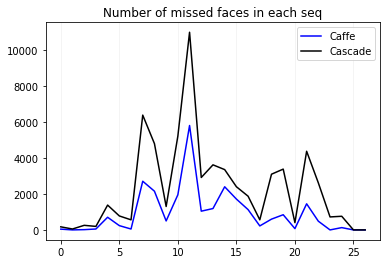

In [303]:
x = range(len(lack_faces_Caffe))

plt.plot(x, lack_faces_Caffe, color='blue', label='Caffe')
plt.plot(x, lack_faces_Cascade, color='black', label='Cascade')

plt.grid(axis='x', color='0.95')
plt.legend()
plt.title('Number of missed faces in each seq')
plt.show()

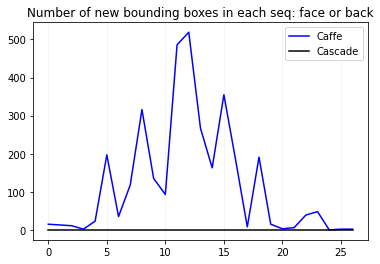

In [304]:
x = range(len(new_faces_Caffe))

plt.plot(x, new_faces_Caffe, color='blue', label='Caffe')
plt.plot(x, new_faces_Cascade, color='black', label='Cascade')

plt.grid(axis='x', color='0.95')
plt.legend()
plt.title('Number of new bounding boxes in each seq: face or back')
plt.show()

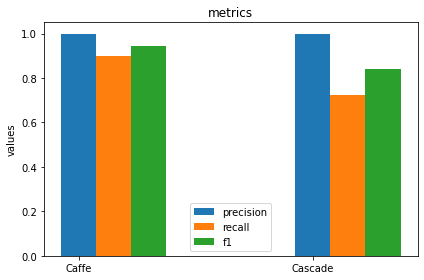

In [305]:

labels = ["Caffe", "Cascade"]
x = np.arange(len(labels))  # the label locations

width = 0.15  # the width of the bars

fig, ax = plt.subplots()

for k in range(len(metrics)):
    
    ax.bar(x + k*width, metrics[list(metrics.keys())[k]], width, label='{}'.format(list(metrics.keys())[k]))
    

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('values')
ax.set_title('metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

In [ ]:
img = cv2.resize(frame[y:y1, x:x1], (height, width)) 
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)

score_eval = tf.nn.softmax(predictions[0])
label_pred.append(np.argmax(score_eval))
                            
iou = 0
                            
for face_box in face_boxes :                                 
    iou = max (intersection_over_union(face_box, (x, y, x1, y1)), iou)

    if iou < 0.4 or len(face_boxes) < 0  : 
        label_gt.append(0)
    else:
        label_gt.append(1)
                                
if len(faces) < 0 and len(face_boxes)  > 0:
    lack_faces+=1
    
#font = cv2.FONT_HERSHEY_SIMPLEX 
#cv2.putText(frame,'iou {:.2f}'.format(iou)+' predict '+str(pred), (50, 50+50*i),font, 1, (0, 255, 255), 2, cv2.LINE_4) 
                    

In [307]:
import dlib
import face_recognition